In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/model_train/11_review')

In [3]:
%tensorflow_version 1.x
from keras.callbacks import Callback
from glob import glob
import os
class LossHistory(Callback):
    def __init__(self,snapshot_freq=5,keep_weights_file_num=5,train_local='./backup'):
        super(LossHistory, self).__init__()
        self.snapshot_freq = snapshot_freq
        self.keep_weights_file_num = keep_weights_file_num
        self.train_local = train_local

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.snapshot_freq == 0:
            save_path = os.path.join(self.train_local, 'weights_%03d_%.4f.h5' % (epoch, logs.get('val_acc')))
            # self.model.save_weights(save_path)
            self.model.save(save_path)
            print('save weights file', save_path)

        if self.keep_weights_file_num > -1:
            weights_files = glob(os.path.join(self.train_local, '*.h5'))
            if len(weights_files) >= self.keep_weights_file_num:
                weights_files.sort(key=lambda file_name: os.stat(file_name).st_ctime, reverse=True)
                for file_path in weights_files[self.keep_weights_file_num:]:
                    os.remove(file_path)  # only remove weights files on local path

Using TensorFlow backend.


#### 1、根据keras自己的数据生成器ImageDataGenerator训练模型

In [9]:
%tensorflow_version 1.x
from keras.models import Sequential,load_model
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout
from keras.preprocessing.image import img_to_array,array_to_img,ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,TensorBoard
import os

hasModelName = './backup/weights_015_0.9750.h5'
useTrainedModel = 0             # 是否在已训练模型文件的基础上继续加载训练
# LossHistory中的参数设置
train_local = './backup'          # 模型文件的存储位置
if not os.path.exists(train_local):
    os.mkdir(train_local)

trainGen = ImageDataGenerator(rotation_range=20, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2,rescale=1/255)
testGen = ImageDataGenerator(rescale=1/255)
trainData = trainGen.flow_from_directory('image/train',target_size=(224,224),batch_size=8)
testData = testGen.flow_from_directory('image/test',target_size=(224,224),batch_size=8)

sgd = SGD(lr=1e-4,momentum=0.9)
es = EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=9, mode='auto',verbose=1)
rl = ReduceLROnPlateau(monitor='val_acc', min_delta=1e-4, patience=3, factor=0.2, mode='auto',verbose=1,min_lr=1e-7)
losshistory = LossHistory()
tensorboard = TensorBoard(log_dir='./logs',batch_size=8,write_images=True)

if useTrainedModel:
    print('已有训练过的模型,正在加载中……')
    os.chdir(hasModelName[:9])
    model = load_model(hasModelName.split('/')[-1])
    os.chdir('../')
else:
    print('开始训练新的模型')
    rs = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

    second_model = Sequential()
    second_model.add(Flatten(input_shape=rs.output_shape[1:]))
    second_model.add(Dense(units=1024, activation='relu',kernel_initializer='he_normal'))
    second_model.add(Dropout(0.5))
    second_model.add(Dense(units=2,activation='sigmoid'))

    model = Sequential()
    model.add(rs)
    model.add(second_model)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(trainData, steps_per_epoch=len(trainData), epochs=101,
          validation_data=testData, validation_steps=len(testData), 
          callbacks=[es,rl,losshistory,tensorboard])
print('train done.')

# model.save('cat_or_dog_classifier.h5')


Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
开始训练新的模型





/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 7s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Epoch 1/101
50/50 [==============================] - 333s 7s/step - loss: 0.6963 - acc: 0.6225 - val_loss: 0.5539 - val_acc: 0.6900
save weights file ./backup/weights_000_0.6900.h5

Epoch 2/101
50/50 [==============================] - 21s 417ms/step - loss: 0.5377 - acc: 0.6550 - val_loss: 0.4297 - val_acc: 0.7350
Epoch 3/101
50/50 [==============================] - 21s 414ms/step - loss: 0.4730 - acc: 0.7675 - val_loss: 0.3599 - val_acc: 0.9150
Epoch 4/101
50/50 [==============================] - 21s 412ms/step - loss: 0.3521 - acc: 0.8475 - val_loss: 0.1294 - val_acc: 0.9500
Epoch 5/101
50/50 [==============================] - 21s 414ms/step - loss: 0.2262 - acc: 0.9200 - val_loss: 0.0832 - val_acc: 0.9650
E

#### 2、根据data_gen.py文件得到模型所需的数据
这样的优点是可以使用PIL对图像进行数据增强操作，不必只局限于ImageDataGenerator中提供的数据增强操作；不必关心训练集和验证集的划分，因为data_gen中会利用sklearn.model_selection.StratifiedShuffleSplit去更随机的划分数据集

In [10]:
%tensorflow_version 1.x
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from keras.layers import Dense,Dropout,Conv2D,MaxPool2D,Flatten
from keras.optimizers import SGD,Adam
from keras.preprocessing.image import img_to_array,array_to_img,ImageDataGenerator
from keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau,TensorBoard

from data_gen import data_flow

batchSize = 8
inputSize = 224
valNum = 60
numClass = 2
epoch = 101


trainData, valData = data_flow(train_data_dir='image/',batch_size=batchSize,input_size=inputSize,val_num=valNum,num_classes=numClass)

sgd = SGD(lr=1e-4,momentum=0.9)
earlystopping = EarlyStopping(monitor='val_loss',patience=9,min_delta=1e-4,mode='auto',verbose=1)
reduceLr = ReduceLROnPlateau(monitor='val_loss',patience=3,min_delta=1e-4,factor=0.2,min_lr=1e-7,mode='auto',verbose=1)
tensorboard = TensorBoard('./logs',batch_size=batchSize,write_images=True)
losshistory = LossHistory()

rs = ResNet50(input_shape=(inputSize,inputSize,3),weights='imagenet',include_top=False)

second_model = Sequential()
second_model.add(Flatten(input_shape=rs.output_shape[1:]))
second_model.add(Dense(units=1024,activation='relu',kernel_initializer='he_normal'))
second_model.add(Dropout(0.5))
second_model.add(Dense(units=2,activation='sigmoid',kernel_initializer='he_normal'))

model = Sequential()
model.add(rs)
model.add(second_model)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(trainData,steps_per_epoch=len(trainData), epochs=epoch,
     validation_data=valData,validation_steps=len(valData),
     callbacks=[earlystopping,reduceLr,tensorboard,losshistory])


dog 对应的编号为 1
cat 对应的编号为 0
dog 对应的编号为 1
cat 对应的编号为 0


total samples: 600, training samples: 540, validation samples: 60


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/101
68/68 [==============================] - 35s 518ms/step - loss: 0.6240 - acc: 0.7849 - val_loss: 0.1640 - val_acc: 0.9833
save weights file ./backup/weights_000_0.9833.h5
Epoch 2/101
68/68 [==============================] - 26s 383ms/step - loss: 0.2200 - acc: 0.9191 - val_loss: 0.0646 - val_acc: 0.9833
Epoch 3/101
68/68 [==============================] - 26s 380ms/step - loss: 0.1410 - acc: 0.9522 - val_loss: 0.0841 - val_acc: 0.9667
Epoch 4/101
68/68 [==============================] - 26s 380ms/step - loss: 0.1218 - acc: 0.9559 - val_loss: 0.0802 - val_acc: 0.9667
Epoch 5/101
68/68 [==============================] - 26s 380ms/step - loss: 0.0664 - acc: 0.9724 - val_loss: 0.0942 - val_acc: 0.9667

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 6/101
68/68 [==============================] - 26s 380ms/step - loss: 0.0834 - acc: 0.9743 - val_loss: 0.0959 - val_acc: 0.9667
save weights file ./backup/weights_005_0.9667.h5
Epoch 7/101
68/6

#### 3、根据训练的模型预测单张图片


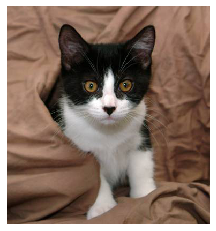

['cat']


In [15]:
from keras.models import load_model
from keras.preprocessing.image import img_to_array,array_to_img,load_img
import numpy as np
import matplotlib.pyplot as plt

model = load_model('./backup/weights_010_0.9667.h5')

img = load_img('cat.1002.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

img = img.resize((224,224))
img = img_to_array(img)/255
img = np.expand_dims(img,0)
# labels = ['cat','dogs']  # 必须是np.array()格式
labels = np.array(['cat','dog'])
print(labels[model.predict_classes(img)])
